# ***Version 04***
  - v04: Added one more Model (ViT), Removed Grad-CAM++ function
  - v03: Added Grad-CAM and Grad-CAM++ (eXplainable AI) for XceptionNet
  - v02: Added Data Augmentation to prevent overfitting
  - v01: Initial base model
---




*   Topic:
    Deepfake Detection with Images
*   Models:
    XceptionNet, EfficientNet-B0
*   Developement Environment:
  1.   Google Colab
  2.   Tesla T4 GPU
  3.   PyTorch
*   Dataset: https://www.kaggle.com/datasets/shahzaibshazoo/detect-ai-generated-faces-high-quality-dataset?resource=download
*   Research Questions
  1.   How does the architectural difference between EfficientNet-B0 and XceptionNet influence their performance in detecting deepfake images?
  2.   Which model, EfficientNet-B0 or XceptionNet, demonstrates higher accuracy and computational efficiency in detecting deepfake images?
  3.   How does data augmentation impact the performance of deepfake image detection models trained on imbalanced datasets?
  4.   How do the Grad-CAM visualizations of each model, as an Explainable AI (XAI) technique, differ in terms of feature extraction for deepfake detection?
  






# 1. Install Packages

In [ ]:
!pip install efficientnet_pytorch # For EfficientNet
!pip install timm # For XceptionNet
!pip install torch torchvision matplotlib numpy # For grad-CAM

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.6 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=7ef19636433e9568c4af04f79c76f3489bc6ceb3b9d94e469

# 2. Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import timm
import matplotlib.pyplot as plt
import os
import shutil
import random
import time
import seaborn as sns
import numpy as np
import cv2

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
from glob import glob
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, accuracy_score, roc_curve, auc
from google.colab import drive
from PIL import Image


# 3. Drive Mount

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# 4. Prepare Models (XceptionNet and EfficientNet-B0)

In [ ]:
model_xception = timm.create_model('xception', pretrained=True, num_classes=2)
model_efficient = EfficientNet.from_pretrained('efficientnet-b0')
model_efficient._fc = nn.Linear(model_efficient._fc.in_features, 2)

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 123MB/s] 


Loaded pretrained weights for efficientnet-b0


# 5. Split the data into 80% training, 10% validation and 10% test

In [ ]:
# # Path for image folder
# base_dir = '/content/drive/MyDrive/datasets/deepfake'
# output_dir = '/content/drive/MyDrive/datasets/deepfake/split_dataset'

# # Split real/AI dataset
# classes = ['AI', 'real']
# train_ratio = 0.8
# validation_ratio = 0.1

# for cls in classes:
#     img_paths = glob(os.path.join(base_dir, cls, '*'))
#     total_count = len(img_paths)
#     random.shuffle(img_paths)

#     train_end = int(total_count * train_ratio)
#     validation_end = train_end + int(total_count * validation_ratio)

#     train_imgs = img_paths[:train_end]
#     validation_imgs = img_paths[train_end:validation_end]
#     test_imgs = img_paths[validation_end:]

#     # make directory
#     for phase in ['train', 'validation', 'test']:
#         target_dir = os.path.join(output_dir, phase, cls)
#         os.makedirs(target_dir, exist_ok=True)

#     # copy images
#     for img_path in train_imgs:
#         shutil.copy(img_path, os.path.join(output_dir, 'train', cls))

#     for img_path in validation_imgs:
#         shutil.copy(img_path, os.path.join(output_dir, 'validation', cls))

#     for img_path in test_imgs:
#         shutil.copy(img_path, os.path.join(output_dir, 'test', cls))

#     # print the number of images after splitting
#     print(f"[{cls}] Total number of images: {total_count}")
#     print(f"[{cls}] Number of training images: {len(train_imgs)}")
#     print(f"[{cls}] Number of validation images: {len(validation_imgs)}")
#     print(f"[{cls}] Number of test images: {len(test_imgs)}")
#     print('-' * 40)

# print("Image split and copy completed.")


# 6. Dataset Preprocessing and Loading

In [ ]:
#transform = transforms.Compose([
#    transforms.Resize((224, 224)),
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
#])

# Data Augmentation (to prevent overfitting)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),     # Horizontal flip
    transforms.RandomRotation(20),         # Random rotation within 20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust color properties
    transforms.RandomResizedCrop(224),     # Random crop and resize to 224x224
    transforms.ToTensor(),                 # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with mean and std
])

#train_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/split_dataset/train', transform=transform)
#validation_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/split_dataset/validation', transform=transform)
#test_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/split_dataset/test', transform=transform)

train_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/test_YJ/train', transform=transform)
validation_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/test_YJ/validation', transform=transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/test_YJ/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# 7. Define Grad-CAM

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx):
        self.model.zero_grad()
        output = self.model(input_tensor)
        target = output[:, class_idx].sum()
        target.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)

        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() + 1e-6)  # Normalize
        cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))
        return cam

    def visualize_cam(self, input_tensor, cam):
        # Convert input tensor to numpy image
        img_tensor = input_tensor[0].cpu().permute(1, 2, 0).detach().numpy()
        img_tensor = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min() + 1e-8)
        img_np = np.clip(img_tensor, 0, 1)

        # Normalize CAM
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-8)

        # If cam has more than 1 channel, select one (e.g., first channel or average)
        if cam.ndim == 3 and cam.shape[2] == 7:
            cam = np.mean(cam, axis=-1)  # Average across channels (or use cam[:, :, 0] for first channel)

        # Convert to uint8
        cam_uint8 = np.uint8(255 * cam)

        # Apply heatmap
        heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255

        # Resize heatmap if necessary
        if heatmap.shape[:2] != img_np.shape[:2]:
            heatmap = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))

        # Superimpose
        superimposed_img = heatmap + img_np
        superimposed_img = superimposed_img / np.max(superimposed_img)
        return superimposed_img





# 8. Define the training function

In [ ]:
#def train_model(model, train_loader, validation_loader, epochs=10):


def train_model(model, train_loader, validation_loader, epochs=1):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    train_precisions, train_recalls, train_f1s, train_aucs = [], [], [], []
    val_precisions, val_recalls, val_f1s, val_aucs = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        all_train_preds = []
        all_train_labels = []

        # Train
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backpropagation
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

            all_train_preds.extend(outputs.argmax(1).cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        train_accuracy = correct / len(train_loader.dataset)
        train_precision = precision_score(all_train_labels, all_train_preds, average='weighted')
        train_recall = recall_score(all_train_labels, all_train_preds, average='weighted')
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
        train_auc = roc_auc_score(all_train_labels, all_train_preds)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        all_val_preds = []
        all_val_labels = []

        ########### CPU로 할때는 with torch.no_grad() 주석처리하고 바로아래 for문 땡겨서 테스트. GPU로 하면 with 주석 풀고 for 문 그 안에 넣어야돼
        #with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

            all_val_preds.extend(outputs.argmax(1).cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())

        val_accuracy = val_correct / len(validation_loader.dataset)
        val_precision = precision_score(all_val_labels, all_val_preds, average='weighted')
        val_recall = recall_score(all_val_labels, all_val_preds, average='weighted')
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
        val_auc = roc_auc_score(all_val_labels, all_val_preds)

        #
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss / len(validation_loader))
        val_accuracies.append(val_accuracy)

        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)
        train_aucs.append(train_auc)

        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        val_aucs.append(val_auc)

        print(f"Epoch {epoch+1}: Train Loss={running_loss:.4f}, Acc={train_accuracy:.4f} | " f"Val Loss={val_loss:.4f}, Acc={val_accuracy:.4f}")

    # Metrics Graphs
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                 train_precisions, val_precisions,
                 train_recalls, val_recalls,
                 train_f1s, val_f1s,
                 train_aucs, val_aucs)



# 9. Define the evaluation fuction

In [ ]:
def evaluate_model(model, dataloader):

    ######################### GPU 버전에서 이부분 추가
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    y_true = []
    y_pred = []
    y_probs = []  # Store probabilities for ROC curve

    device = torch.device("cpu")  # 모델을 CPU로 설정


    model = model.to(device)


    grad_cam = GradCAM(model, model.conv4.pointwise)  # Xception last conv layer
    grad_cam.register_hooks()


    ########### CPU로 할때는 with torch.no_grad() 주석처리하고 바로아래 for문 땡겨서 테스트. GPU로 하면 with 주석 풀고 for 문 그 안에 넣어야돼
    #with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # Convert logits to probabilities
        probs = F.softmax(outputs, dim=1)
        preds = outputs.argmax(1).cpu()

        y_pred.extend(preds.numpy())
        y_true.extend(labels.numpy())


        y_probs.extend(probs[:, 1].detach().cpu().numpy())
        ################## CPU로 테스트할땐 위에꺼로, GPU로 하면 아래
        #y_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class '1' (AI)


        ###################### GPU 버전에서는 이거 제거.
        model = model.to(device)  # 모델을 CPU로 이동

        # Grad-CAM for AI class
        grad_cam_ai = GradCAM(model, model.conv4.pointwise)  # Xception last conv layer
        grad_cam_ai.register_hooks()
        cam_ai = grad_cam_ai.generate_cam(images, class_idx=1)  # AI class (index 1)
        superimposed_img_ai = grad_cam_ai.visualize_cam(images, cam_ai)

        plt.imshow(superimposed_img_ai)
        plt.axis('off')
        plt.title(f"AI Class Grad-CAM (Probability: {probs[0][1]:.4f})")
        plt.show()

        # Grad-CAM for real class
        grad_cam_real = GradCAM(model, model.conv4.pointwise)
        grad_cam_real.register_hooks()
        cam_real = grad_cam_real.generate_cam(images, class_idx=0)  # Real class (index 0)
        superimposed_img_real = grad_cam_real.visualize_cam(images, cam_real)

        plt.imshow(superimposed_img_real)
        plt.axis('off')
        plt.title(f"Real Class Grad-CAM (Probability: {probs[0][0]:.4f})")
        plt.show()

        # Grad-CAM for predicted class
        grad_cam = GradCAM(model, model.conv4.pointwise)
        grad_cam.register_hooks()
        cam = grad_cam.generate_cam(images, class_idx=preds[0].item())
        superimposed_img = grad_cam.visualize_cam(images, cam)

        plt.imshow(superimposed_img)
        plt.axis('off')
        plt.title(f"Predicted: {preds[0].item()}, AI Probability: {probs[0][1]:.4f}")
        plt.show()




    # Print classification report (precision, recall, F1-score)
    print(classification_report(y_true, y_pred, target_names=['real', 'AI']))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['real', 'AI'], yticklabels=['real', 'AI'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Diagonal reference line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


# 10.Make metrics/graphs

In [ ]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                 train_precisions, val_precisions,
                 train_recalls, val_recalls,
                 train_f1s, val_f1s,
                 train_aucs, val_aucs):
    # Loss
    plt.figure(figsize=(14, 10))
    plt.subplot(3, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(3, 2, 2)
    plt.plot(train_accuracies, label='Train')
    plt.plot(val_accuracies, label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Precision
    plt.subplot(3, 2, 3)
    plt.plot(train_precisions, label='Train')
    plt.plot(val_precisions, label='Validation')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    # Recall
    plt.subplot(3, 2, 4)
    plt.plot(train_recalls, label='Train')
    plt.plot(val_recalls, label='Validation')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    # F1-Score
    plt.subplot(3, 2, 5)
    plt.plot(train_f1s, label='Train')
    plt.plot(val_f1s, label='Validation')
    plt.title('F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()

    # AUC
    plt.subplot(3, 2, 6)
    plt.plot(train_aucs, label='Train')
    plt.plot(val_aucs, label='Validation')
    plt.title('AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 11. Set up device (GPU)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 12-1. Train XceptionNet

Training XceptionNet...
----------------------------------------
Epoch 1: Train Loss=0.6682, Acc=0.6000 | Val Loss=0.6017, Acc=1.0000


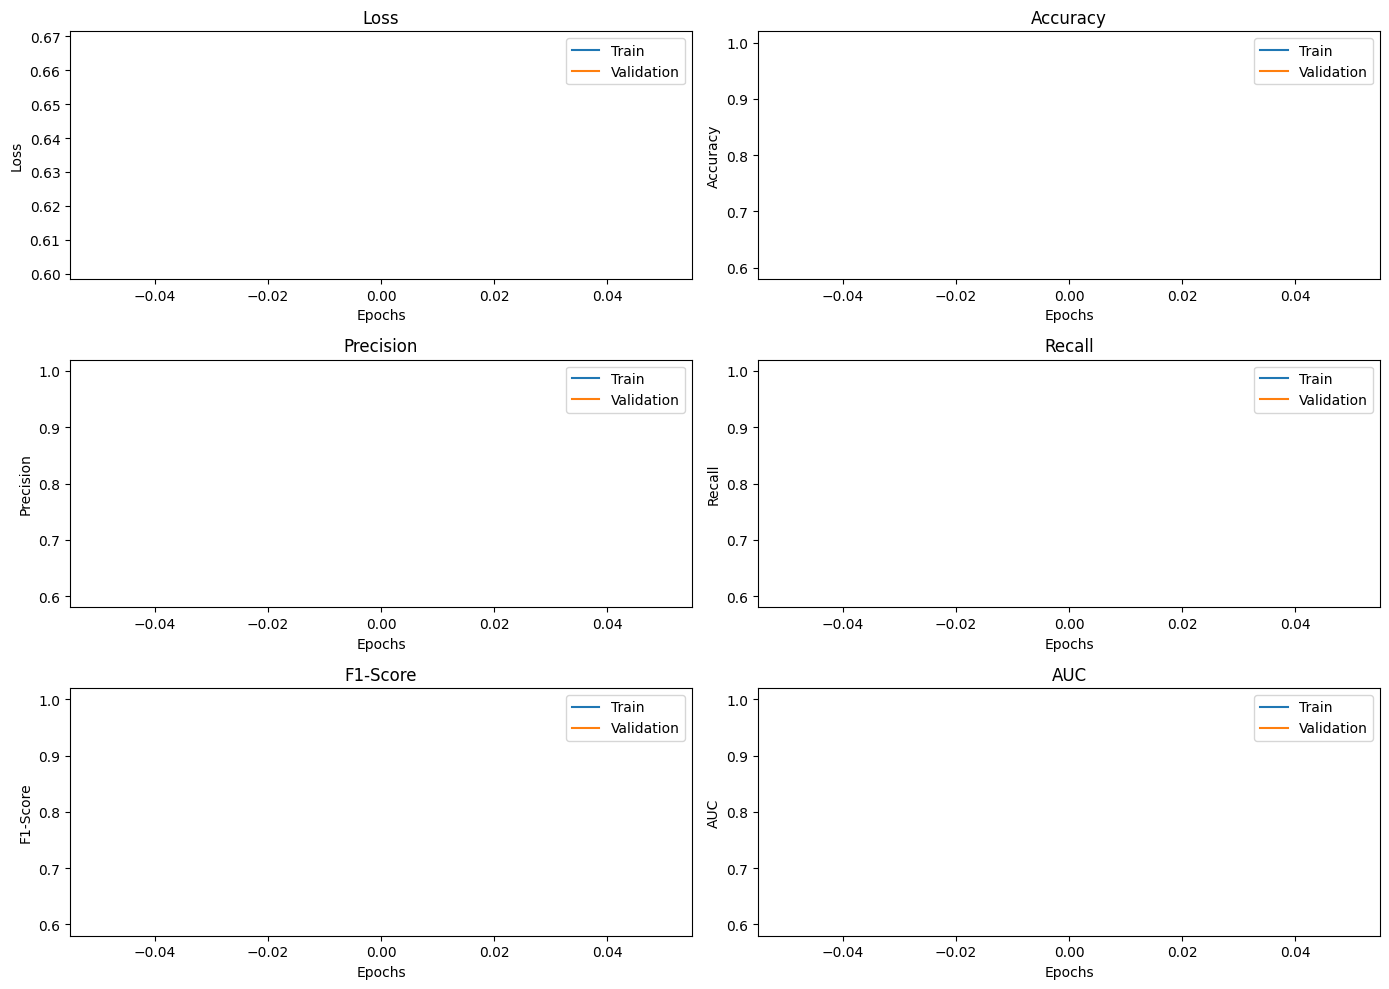

----------------------------------------
Training completed in 0.45 minutes


In [ ]:
print("Training XceptionNet...")
print('-' * 40)
start_time = time.time()

#train_model(model_xception, train_loader, validation_loader, epochs=10)

train_model(model_xception, train_loader, validation_loader, epochs=1)

end_time = time.time()
elapsed_time = end_time - start_time
print('-' * 40)
print(f"Training completed in {elapsed_time / 60:.2f} minutes")

# 12-2. Evaluate XceptionNet

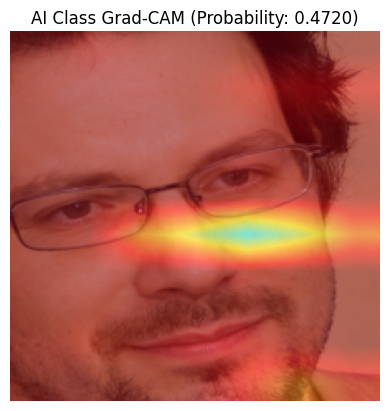

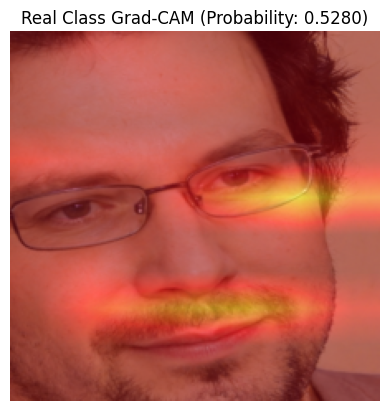

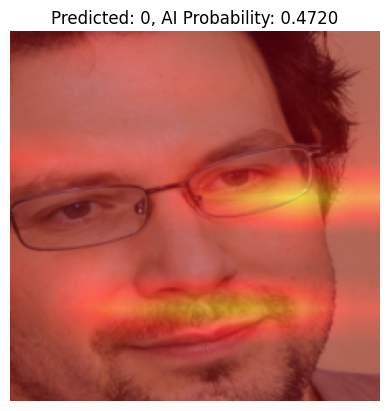

              precision    recall  f1-score   support

        real       0.75      0.60      0.67         5
          AI       0.67      0.80      0.73         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10



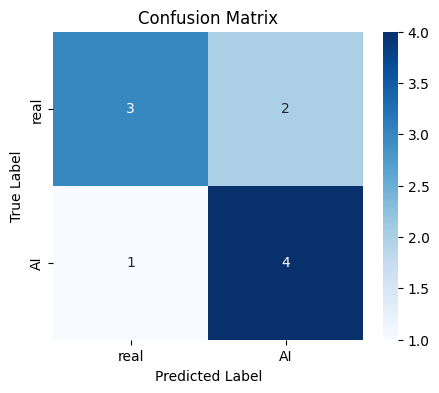

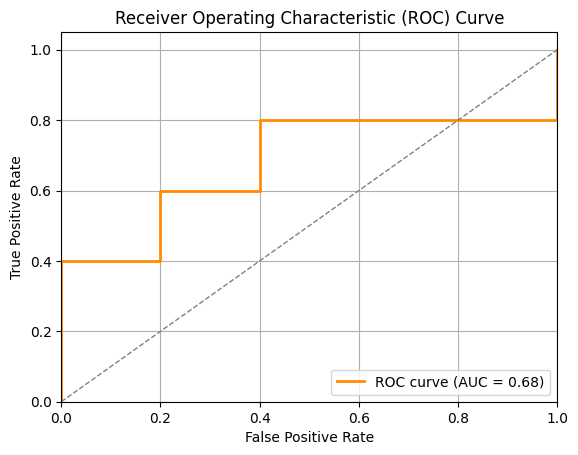

In [ ]:
#print(model_xception)

evaluate_model(model_xception, test_loader)

# 13-1. Train EfficientNet-B0

In [ ]:
print("Training EfficientNet-B0...")
print('=' * 40)
start_time = time.time()

train_model(model_efficient, train_loader, validation_loader, epochs=10)

end_time = time.time()
elapsed_time = end_time - start_time
print('=' * 40)
print(f"Training completed in {elapsed_time / 60:.2f} minutes")



Training EfficientNet-B0...
Epoch 1: Train Loss=0.7157, Acc=0.4000 | Val Loss=0.7321, Acc=0.5000
Epoch 2: Train Loss=0.6919, Acc=0.6000 | Val Loss=0.7534, Acc=0.4000
Epoch 3: Train Loss=0.6675, Acc=0.6000 | Val Loss=0.7232, Acc=0.5000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4: Train Loss=0.6427, Acc=0.8000 | Val Loss=0.7067, Acc=0.6000


KeyboardInterrupt: 

# 13-2. Evaluate EfficientNet-B0

In [ ]:
#print(model_efficient)

evaluate_model(model_efficient, test_loader)

# Vision Transformer(ViT)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Epoch 1/3, Loss: 0.7789
Epoch 2/3, Loss: 0.4112
Epoch 3/3, Loss: 0.2216


`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Accuracy: 0.5
              precision    recall  f1-score   support

          AI       0.50      0.20      0.29         5
        real       0.50      0.80      0.62         5

    accuracy                           0.50        10
   macro avg       0.50      0.50      0.45        10
weighted avg       0.50      0.50      0.45        10



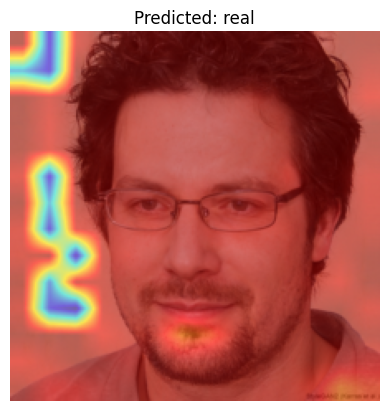

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from torchvision import datasets

# Load pretrained ViT model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=2,
    ignore_mismatched_sizes=True
)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

# Load feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

# Custom transform using ViT feature extractor
class ViTTransform:
    def __call__(self, image):
        encoding = feature_extractor(images=image, return_tensors="pt")
        return encoding['pixel_values'].squeeze(0)

transform = ViTTransform()

# Load dataset
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/test_YJ/train', transform=transform)
validation_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/test_YJ/validation', transform=transform)
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/datasets/deepfake/test_YJ/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training loop
epochs = 3
model.train()
for epoch in range(epochs):
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(pixel_values=images)
        loss = criterion(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(pixel_values=images)
        preds = torch.argmax(outputs.logits, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

# XAI: ViT Grad-CAM alternative using attention from outputs
from PIL import Image
import torch.nn.functional as F

def visualize_vit_attention(model, image_tensor, class_names):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)
    outputs = model(pixel_values=image_tensor, output_attentions=True)
    pred_class = outputs.logits.argmax(dim=-1).item()

    # Use attention weights from last layer (average all heads)
    attn = outputs.attentions[-1]  # shape: [1, num_heads, num_tokens, num_tokens]
    attn = attn.mean(dim=1)  # shape: [1, num_tokens, num_tokens]

    # Take CLS token's attention to all patches (exclude CLS-to-CLS)
    cls_attn = attn[0, 0, 1:]  # shape: [196]
    cls_attn = cls_attn.reshape(14, 14).detach().cpu().numpy()
    cls_attn = (cls_attn - cls_attn.min()) / (cls_attn.max() + 1e-8)
    cls_attn = cv2.resize(cls_attn, (224, 224))

    # Convert input tensor to image
    img_np = image_tensor[0].detach().cpu().permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

    heatmap = cv2.applyColorMap(np.uint8(255 * cls_attn), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + img_np
    overlay = overlay / overlay.max()

    plt.imshow(overlay)
    plt.title(f"Predicted: {class_names[pred_class]}")
    plt.axis('off')
    plt.show()

# Visualize attention on the first test image
first_img_path, _ = test_dataset.samples[0]
first_img = Image.open(first_img_path).convert('RGB')
first_tensor = transform(first_img)
visualize_vit_attention(model, first_tensor, train_dataset.classes)
